<center><h1> Multi radar analysis </h1></center>

In [1]:
import pyart
import os
import numpy as np
from matplotlib import pyplot as plt
import netCDF4  
from IPython.parallel import Client

%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/scollis/anaconda/envs/kazrtools/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
def granule(arg_dict):
    def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
        return idx

    def snr_toa(radar):
        toa = 12.5*1000.0
        snr = radar.fields['snr_copol']['data']
        ranges = radar.range['data']
        cloud_top_gate = find_nearest(ranges, toa)
        mean_snr_clear = snr[:, cloud_top_gate::].mean(axis=1)
        return mean_snr_clear
    
    def mean_snr(radar):
        snr = radar.fields['snr_copol']['data']
        mean_total = snr.mean(axis=1)
        return mean_total
    
    in_file = arg_dict['filename']
    log_dir = '/data/radar/output/'
    logfilename = os.path.join(log_dir, in_file.split('/')[-1])
    
    fh = open(logfilename, 'w')
    
    fh.write('opening \n')
    radar = pyart.io.read(in_file)
    fh.write('calculating \n')
    units = radar.time['units']
    
    toa_bg = snr_toa(radar)
    all_mean = mean_snr(radar)
    del(radar)
    fh.write('done \n')
    return units, all_mean, toa_bg
    

In [3]:
in_dir = '/data/radar/oli_kazr/'
all_files = os.listdir(in_dir)
good_files = []
for fil in all_files:
    if '.nc' in fil:
        good_files.append(fil)
good_files.sort()

In [4]:
print(len(good_files))

74


In [5]:
packing = []
for fn in good_files:
    this_rec = {'filename' : os.path.join(in_dir, fn)}
    packing.append(this_rec)

In [6]:
My_Cluster = Client()
My_View = My_Cluster[:]
print(My_View)
print(len(My_View))

<DirectView [0, 1, 2, 3,...]>
20


/home/scollis/anaconda/envs/kazrtools/lib/python3.5/site-packages/ipyparallel/client/client.py:318: DeprecationWarning: Client._profile_default is deprecated in traitlets 4.1: use @default decorator instead.
  def _profile_default(self):


In [7]:
My_View.block = False
My_View.execute('import matplotlib')
My_View.execute('matplotlib.use("agg")')
My_View.execute('import pyart')
My_View.execute('import numpy as np')
My_View.execute('import os')



result = My_View.map_async(granule, packing)
qvps = result.get()

In [17]:
qvpsa = np.array(qvps)

ValueError: setting an array element with a sequence

In [18]:
times = np.array([item[0] for item in  qvps])
alls = np.array([item[1] for item in  qvps])
toas = np.array([item[2] for item in  qvps])

In [19]:
order = np.argsort(times)

In [29]:
alls_o = np.concatenate(alls[order])
toas_o = np.concatenate(toas[order])

In [26]:
print(alls_o)

[-20.85199356 -20.8426609  -20.80809593 ..., -19.81829453 -19.8259449
 -19.59505463]


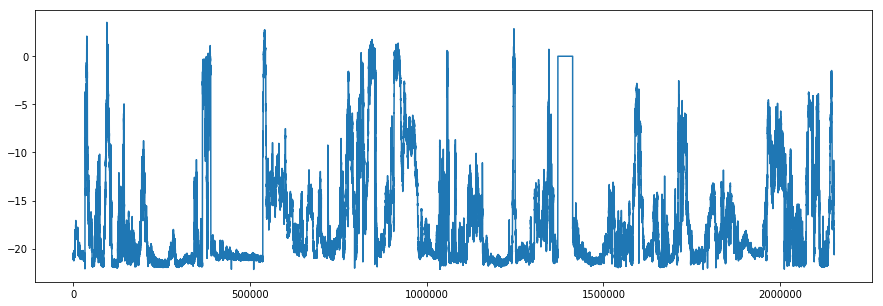

In [28]:
fig = plt.figure(figsize = [15,5])
plt.plot(alls_o)

(-24, -20)

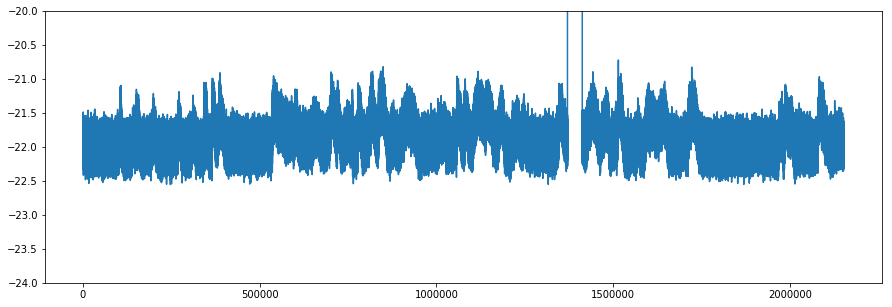

In [32]:
fig = plt.figure(figsize = [15,5])
plt.plot(toas_o)
plt.ylim([-24,-20])